In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1 Load the dataset and explore the variables
customers=pd.read_csv('customer_churn.csv')
customers.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#2 We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
customers = customers[['SeniorCitizen','tenure','MonthlyCharges','Churn']]
customers

,SeniorCitizen,tenure,MonthlyCharges,Churn
0,0,1,29.85,No
1,0,34,56.95,No
2,0,2,53.85,Yes
3,0,45,42.30,No
4,0,2,70.70,Yes
...,...,...,...,...
7038,0,24,84.80,No
7039,0,72,103.20,No
7040,0,11,29.60,No
7041,1,4,74.40,Yes


In [4]:
# 3 Split the Dataset into X ('tenure', 'SeniorCitizen', 'MonthlyCharges') and y ('Churn')
# Churn is dicotomic variable, so I can convert Yes=1 and No=0.

In [5]:
def transform_Churn(x):
    if x == 'Yes':
        return 1
    else:
        return 0

customers['Churn'] = list(map(transform_Churn,customers['Churn']))

In [6]:
customers.head(6)

,SeniorCitizen,tenure,MonthlyCharges,Churn
0,0,1,29.85,0
1,0,34,56.95,0
2,0,2,53.85,1
3,0,45,42.30,0
4,0,2,70.70,1
5,0,8,99.65,1


In [7]:
customers.describe()

,SeniorCitizen,tenure,MonthlyCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


In [8]:
#All columns we have are numericals, so we don't need encode any. Besides the values are not high enough to scale them. 

In [9]:
X = customers.drop(['Churn'], axis=1)
y = customers['Churn']

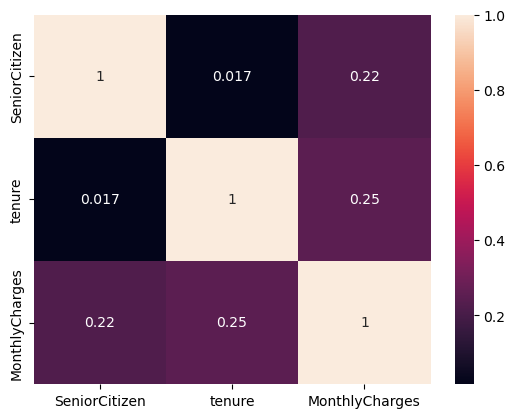

In [10]:
correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [11]:
# Correlation scores in the heat map don't show a multicoinearity between the variables, so we don't have to drop any variable.

<Axes: >

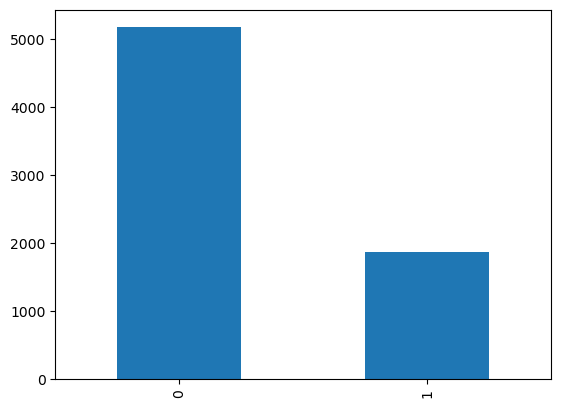

In [12]:
balance_target = pd.value_counts(customers['Churn'])
balance_target.plot(kind = 'bar')

In [13]:
# There are much more 0(No) than 1(Yes)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X_train)
X_std_train = transformer.transform(X_train)
X_std_train = pd.DataFrame(X_std_train,columns=X.columns)

X_std_test = transformer.transform(X_test)
X_std_test = pd.DataFrame(X_std_test,columns=X.columns)

In [16]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state =0, solver='lbfgs').fit(X_std_train,y_train)
classification.score(X_std_test, y_test)

0.7936583057264552

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predictions = classification.predict(X_std_test)

print("precision: ",precision_score(y_test,predictions))
print("recall: ",recall_score(y_test,predictions))
print("f1: ",f1_score(y_test,predictions))

precision:  0.6835106382978723
recall:  0.44773519163763065
f1:  0.5410526315789473


In [18]:
# The score in recall: 0.447. That shows is not a good enough model. Very likely due to imbalance data. 

In [19]:
# Matrix confusion.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[1420,  119],
       [ 317,  257]], dtype=int64)

In [20]:
# Model predcits. True positives = 1420, False negatives = 317, True negatvives = 257, False positives = 119.

In [21]:
# Let's apply SMOTE (Synthetic Minority Over-sampling Technique) model to lose the imbalance.

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=100,k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_std_train,y_train)

In [23]:
class_smote = LogisticRegression(random_state=0,solver='lbfgs').fit(X_train_SMOTE,y_train_SMOTE)
class_smote.score(X_std_test, y_test)

0.7411263606247042

In [24]:
pred_smote = class_smote.predict(X_std_test)

print("precision: ",precision_score(y_test,pred_smote))
print("recall: ",recall_score(y_test,pred_smote))
print("f1: ",f1_score(y_test,pred_smote))

precision:  0.5161676646706587
recall:  0.7508710801393729
f1:  0.6117814052519518


In [25]:
pred_smote

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [26]:
confusion_matrix(y_test,pred_smote)

array([[1135,  404],
       [ 143,  431]], dtype=int64)

In [27]:
# Precision is a performance metric that measures the proportion of correctly predicted positive instances (true positives)
# out of all instances predicted as positive (true positives + false positives).
# It gives an indication of how well the model is performing in correctly identifying positive instances.

In [28]:
#Precision = 
431 / (431 + 143)

0.7508710801393729

In [29]:
# The model was improved with the SMOTE method. 
#                        BEFORE / AFTER  APPLYING THE MODEL. 

precision:  0.6835106382978723 / 0.5161676646706587
recall:  0.44773519163763065 / 0.7508710801393729
f1:  0.5410526315789473 / 0.6117814052519518

# As we can notice the precision score is lower than before appying the SMOTE method. 
# This can happen because SMOTE introduces synthetic samples that may be closer to the decision boundary, 
# leading to an increase in false positive predictions. As a result, the precision, 
# which measures the ratio of true positives to the total predicted positives, may decrease.